In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statistics
from scipy import stats
from tqdm import tqdm
from scipy.spatial.distance import euclidean
from sklearn.manifold import TSNE
import plotly.express as px
from umap import UMAP
from sklearn.decomposition import PCA
from collections import defaultdict


In [24]:
# Define bin size
BIN_SIZE = 1000000

# Function to count rows with progress
def count_rows_in_file_with_progress(filepath):
    row_count = 0
    with open(filepath, 'r') as file:
        for _ in tqdm(file, desc="Counting rows"):
            row_count += 1
    return row_count

# Function to parse the text files
def parse_file(file_path):
    if count_rows_in_file_with_progress(file_path) >= 1000:
        data = pd.read_csv(file_path, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction'])
        total_sum = data['interaction'].sum()
        cis_contacts = data[data['chr1'] == data['chr2']]['interaction'].sum()
        trans_contacts = data[data['chr1'] != data['chr2']]['interaction'].sum()
        # Calculate the cis:trans ratio
        if trans_contacts == 0:
            cis_trans_ratio = float('inf')  # To handle division by zero
        else:
            cis_trans_ratio = cis_contacts / trans_contacts

        if total_sum >= 1000 and cis_trans_ratio >= 1:
            return data
    print(f"SKIPPED {file_path}")
    return None
    
# Function to create bins based on dynamic max values
def create_bins(data, bin_size):
    max_pos1 = data['pos1'].max()
    max_pos2 = data['pos2'].max()
    max_pos = max(max_pos1, max_pos2)
    
    matrix_size = int(max_pos // bin_size) + 1  # Determine matrix size based on max position
    bins = np.arange(0, (matrix_size + 1) * bin_size, bin_size)
    
    return bins, matrix_size

# Adjust bin counts according to the new requirement
def adjust_bin_counts(bin_counts):
    adjusted_bin_counts = {chr: count // 10 for chr, count in bin_counts.items()}
    return adjusted_bin_counts

# Function to create chromosome bin mapping
def create_chromosome_bin_mapping(bin_counts):
    chr_bin_mapping = {}
    cumulative_bins = 0
    for chr, count in sorted(bin_counts.items()):
        chr_bin_mapping[chr] = (cumulative_bins, cumulative_bins + count)
        cumulative_bins += count
    # print(f"Chromosome Bin Mapping: {chr_bin_mapping}")  # Debugging
    return chr_bin_mapping

# Function to map position to bin after dividing by 1,000,000 and then by 100
def map_position_to_bin(chr, pos, chr_bin_mapping):
    start_bin, _ = chr_bin_mapping[chr]
    bin_index = start_bin + (pos // 1000000) // 10
    # print(f"Mapping: Chr {chr}, Pos {pos}, Bin Index {bin_index}")  # Debugging
    return bin_index

# Function to load data into a contact matrix and track indices
def load_matrix(data, chr_bin_mapping, matrix_size):
    # Map positions to bin indices
    data['bin1'] = data.apply(lambda row: map_position_to_bin(row['chr1'], row['pos1'], chr_bin_mapping), axis=1)
    data['bin2'] = data.apply(lambda row: map_position_to_bin(row['chr2'], row['pos2'], chr_bin_mapping), axis=1)
    
    # Ensure the matrix size is appropriate
    contact_matrix = np.zeros((matrix_size, matrix_size))
    
    # Populate the contact matrix
    for _, row in data.iterrows():
        idx1 = row['bin1']
        idx2 = row['bin2']
        if abs(idx1 - idx2) >= 3:
            if idx1 < matrix_size and idx2 < matrix_size:  # Ensure indices are within bounds
                contact_matrix[idx1, idx2] += row['interaction']
                contact_matrix[idx2, idx1] += row['interaction']
    
    contact_matrix = np.triu(contact_matrix)
    
    return contact_matrix

# Function to load matrices from a directory
def load_matrices(directory, bin_counts):
    adjusted_bin_counts = adjust_bin_counts(bin_counts)
    chr_bin_mapping = create_chromosome_bin_mapping(adjusted_bin_counts)
    matrix_size = sum(adjusted_bin_counts.values())
    
    contact_matrices = []
    filepaths = []
    
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            data = parse_file(filepath)
            if data is not None:
                matrix = load_matrix(data, chr_bin_mapping, matrix_size)
                contact_matrices.append(matrix)
                filepaths.append(filepath)
            else:
                print(f"Data is None for file {filepath}, skipping.")
    
    return contact_matrices, filepaths
    
def find_average(contact_matrices):
    average_list = []
    for matrix in contact_matrices:
        sum = 0
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                sum += matrix[i][j]
        avg = sum / (matrix.shape[0] * matrix.shape[1])
        average_list.append(avg)
    return average_list

def find_average_instance(matrix):
    sum = 0
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            sum += matrix[i][j]
    return sum / (matrix.shape[0] * matrix.shape[1])

def matrix_avg_stats(average_list):
    avg = statistics.mean(average_list)
    sd = statistics.stdev(average_list)
    minimum = min(average_list)
    maximum = max(average_list)
    n = len(average_list)
    return {"average": avg, "standard deviation": sd, "minimum": minimum, "maximum": maximum, "count": n}

def find_max_shape_matrix(genotype: str) -> str:
    addr = ""
    max = (0, 0)
    for file in os.listdir(genotype):
        filepath = os.path.join(genotype, file)
        full = pd.read_csv(filepath, sep='\t', header=None)
        full.columns = ['chr1', 'pos1', 'chr2', 'pos2', 'interaction']
        # Find unique values in column 2 (pos1) and column 4 (pos2)
        full_posx = full['pos1'].unique()
        full_posy = full['pos2'].unique()
        if len(full_posx) > max[0] and len(full_posy) > max[1]:
            max = (len(full_posx), len(full_posy))
            addr = filepath

    return addr

def augment(genotype: str, filepaths: list[str]) -> list[pd.DataFrame]:
    augmented_matrices = []  # Stores all augmented matrices

    max_size_file_path = find_max_shape_matrix(genotype)

    # Find the reference axes
    reference_data = pd.read_csv(max_size_file_path, sep='\t', header=None)
    reference_data.columns = ['chr1', 'pos1', 'chr2', 'pos2', 'interaction']
    
    # Find unique values in column 2 (pos1) and column 4 (pos2)
    unique_posx = reference_data['pos1'].unique()
    unique_posy = reference_data['pos2'].unique()


    full_matrices_dir = []
    for file in os.listdir(genotype):
        filepath = os.path.join(genotype, file)
        if os.path.isfile(filepath):
            data = pd.read_csv(filepath, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction'])
            bins, matrix_size = create_bins(data, BIN_SIZE)
            matrix = load_matrix(data, bins, matrix_size)
            if matrix.shape == (250,250):
                full_matrices_dir.append(filepath)
                augmented_matrices.append(matrix)

    # Find all matrices that are not 400x400
    not_full_matrices = [filepath for filepath in filepaths if filepath not in full_matrices_dir]

    for filepath in not_full_matrices:
        temp_data = pd.read_csv(filepath, sep='\t', header=None)
        temp_data.columns = ['chr1', 'pos1', 'chr2', 'pos2', 'interaction']
        temp_x = temp_data['pos1'].unique()
        temp_y = temp_data['pos2'].unique()
        bins, matrix_size = create_bins(temp_data, BIN_SIZE)
        matrix = load_matrix(temp_data, bins, matrix_size)
        diff_x = np.setdiff1d(unique_posx, temp_x)  # columns missing
        diff_y = np.setdiff1d(unique_posy, temp_y)  # rows missing
        missing_data = reference_data[reference_data['pos1'].isin(diff_x) | reference_data['pos2'].isin(diff_y)]
        aug_data = pd.concat([temp_data, missing_data], ignore_index=True)
        aug_bins, aug_matrix_size = create_bins(aug_data, BIN_SIZE)
        aug_matrix = load_matrix(aug_data, aug_bins, aug_matrix_size)
        augmented_matrices.append(aug_matrix)
    
    return augmented_matrices

def visualize(matrix, vmax) -> None:
    plt.figure(figsize=(10, 10))
    plt.imshow(matrix, cmap='coolwarm', interpolation='none', vmin=0, vmax=vmax)
    plt.colorbar()
    plt.title('Contact Matrix')
    plt.xlabel('Position Bin')
    plt.ylabel('Position Bin')
    plt.show()

def calculate_contact_probability(matrix):
    size = matrix.shape[0]
    probabilities = np.zeros(size)
    
    for d in range(size):
        contact_sum = 0
        count = 0
        for i in range(size - d):
            contact_sum += matrix[i, i + d]
            count += 1
        if count > 0:
            probabilities[d] = contact_sum / count
        else:
            probabilities[d] = 0
    
    return probabilities

def contact_probability_distance(matrix1, matrix2):
    # Calculate contact probabilities
    probabilities1 = calculate_contact_probability(matrix1)
    probabilities2 = calculate_contact_probability(matrix2)
    
    # Calculate the Euclidean distance between the two probability distributions
    distance = euclidean(probabilities1, probabilities2)
    return distance

def compare_matrices_with_windows(matrix1, matrix2, window_size=20):
    matrix_size = matrix1.shape[0]
    result_size = matrix_size // window_size
    result_matrix = np.zeros((result_size, result_size))
    
    for i in tqdm(range(result_size)):
        for j in range(result_size):
            window1 = matrix1[i*window_size:(i+1)*window_size, j*window_size:(j+1)*window_size]
            window2 = matrix2[i*window_size:(i+1)*window_size, j*window_size:(j+1)*window_size]
            distance = mean_absolute_error(window1, window2)
            result_matrix[i, j] = distance
            
    return result_matrix

def sum_of_squared_differences(matrix1, matrix2):
    return round(np.sum((matrix1 - matrix2) ** 2), 3)

def mean_absolute_error(matrix1, matrix2):
    return np.mean(np.abs(matrix1 - matrix2))

def apply_adjacent_smoothing(matrix):
    # Create an output matrix to store the averages
    smoothed_matrix = np.zeros_like(matrix)
    
    # Get the number of rows and columns in the matrix
    rows, cols = matrix.shape
    
    for i in range(rows):
        for j in range(cols):
            # Define the boundaries of the window
            i_min = max(i - 1, 0)
            i_max = min(i + 1, rows - 1)
            j_min = max(j - 1, 0)
            j_max = min(j + 1, cols - 1)
            
            # Extract the window
            window = matrix[i_min:i_max+1, j_min:j_max+1]
            
            # Calculate the average of the window
            smoothed_matrix[i, j] = np.mean(window)
    
    return smoothed_matrix

def count_unique_positions(file_path):
    # Initialize dictionaries to store unique positions for each chromosome
    chr_positions = defaultdict(set)
    
    # Read the file into a pandas DataFrame
    data = pd.read_csv(file_path, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction'])
    
    # Iterate over each row and update the positions sets
    for index, row in data.iterrows():
        chr1, pos1, chr2, pos2 = row['chr1'], row['pos1'], row['chr2'], row['pos2']
        chr_positions[chr1].add(pos1)
        chr_positions[chr2].add(pos2)
    
    return chr_positions

def aggregate_positions(directory):
    # Initialize a dictionary to store aggregated positions for all chromosomes
    aggregate_chr_positions = defaultdict(set)
    
    # Iterate through all files in the directory
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            chr_positions = count_unique_positions(file_path)
            for chr, positions in chr_positions.items():
                aggregate_chr_positions[chr].update(positions)
    
    # Determine the maximum number of bins for each chromosome
    max_bins_per_chr = {chr: len(positions) for chr, positions in aggregate_chr_positions.items()}
    
    # Sort the dictionary by chromosome keys
    sorted_max_bins_per_chr = dict(sorted(max_bins_per_chr.items()))
    
    return sorted_max_bins_per_chr

Determine the BINs

In [4]:
max_bin = {}
max_gm12878 = aggregate_positions("./GM12878")
max_k562 = aggregate_positions("./K562")
max_hap1 = aggregate_positions("./HAP1")
max_hela = aggregate_positions("./Hela")

for key in max_gm12878:
    max_bin[key] = max(max_gm12878[key], 
                       max_k562[key], 
                       max_hap1[key], 
                       max_hela[key])

100%|██████████| 1622/1622 [04:47<00:00,  5.64it/s]


In [36]:
print(max_bin)

{'chr1': 230, 'chr10': 134, 'chr11': 133, 'chr12': 132, 'chr13': 97, 'chr14': 89, 'chr15': 83, 'chr16': 81, 'chr17': 80, 'chr18': 77, 'chr19': 58, 'chr2': 242, 'chr20': 61, 'chr21': 38, 'chr22': 36, 'chr3': 196, 'chr4': 190, 'chr5': 179, 'chr6': 168, 'chr7': 158, 'chr8': 145, 'chr9': 125, 'chrX': 152}


## Analysis for GM12878

In [6]:
# Directory containing the data files
directory = './GM12878'

In [7]:
# Load all contact matrices into a list
contact_matrices_GM12878 = []
filepaths_GM12878 = []

In [8]:
contact_matrices_GM12878, filepaths_GM12878 = load_matrices(directory, max_bin)

num_matrices = len(contact_matrices_GM12878)

print(num_matrices)


Counting rows: 2131it [00:00, 1058635.77it/s]
Counting rows: 6014it [00:00, 2991880.47it/s]
Counting rows: 3103it [00:00, 2681278.39it/s]
Counting rows: 3661it [00:00, 2065000.93it/s]
Counting rows: 3107it [00:00, 1944159.71it/s]
Counting rows: 3075it [00:00, 2491786.09it/s]
Counting rows: 2942it [00:00, 2381710.55it/s]
Counting rows: 3638it [00:00, 2827288.86it/s]
Counting rows: 2602it [00:00, 1257614.54it/s]
Counting rows: 4827it [00:00, 2841131.83it/s]
Counting rows: 2640it [00:00, 1395986.20it/s]
Counting rows: 2398it [00:00, 1410848.79it/s]
Counting rows: 5000it [00:00, 3080875.57it/s]
Counting rows: 5129it [00:00, 2442391.60it/s]
Counting rows: 7150it [00:00, 2732009.98it/s]
Counting rows: 5422it [00:00, 3502466.70it/s]
Counting rows: 3522it [00:00, 1910792.74it/s]
Counting rows: 4184it [00:00, 2126116.78it/s]
Counting rows: 3741it [00:00, 2875369.48it/s]
Counting rows: 3466it [00:00, 3061806.58it/s]
Counting rows: 2952it [00:00, 1668902.20it/s]
Counting rows: 5403it [00:00, 2271

24


In [10]:
print(contact_matrices_GM12878[0].shape)
# augmented_matrices_GM12878 = augment(directory, filepaths_GM12878)

(278, 278)


In [11]:
average_GM12878 = find_average(contact_matrices_GM12878)

average_stats_GM12878 = matrix_avg_stats(average_GM12878)

print(average_GM12878)
print(average_stats_GM12878)

[0.0027172506599037315, 0.010804306195331504, 0.005990890740644894, 0.006611976605765747, 0.0033253972361679002, 0.007362455359453445, 0.0037653330572951713, 0.007064851715749702, 0.005136897676103721, 0.011360695616168936, 0.0031442471921743183, 0.0064049479840587965, 0.009497438020806376, 0.012227627969566793, 0.016057657471145386, 0.010843124061901558, 0.006172040784638476, 0.006728430205475907, 0.005706226385797836, 0.00784120904715077, 0.0036359401687283267, 0.008928109311112261, 0.004774597588116557, 0.003351275813881269]
{'average': 0.007060538619464141, 'standard deviation': 0.0033784585586190156, 'minimum': 0.0027172506599037315, 'maximum': 0.016057657471145386, 'count': 24}


## Analysis for HAP1

In [12]:
directory = './HAP1'

# Load all contact matrices into a list
contact_matrices_HAP1 = []
filepaths_HAP1 = []

# Load in the contact matrices from txt files
contact_matrices_HAP1, filepaths_HAP1 = load_matrices(directory, max_bin)


num_matrices = len(contact_matrices_HAP1)

# augmented_matrices_HAP1 = augment(directory, filepaths_HAP1)

average_HAP1 = find_average(contact_matrices_HAP1)

average_stats_HAP1 = matrix_avg_stats(average_HAP1)

Counting rows: 2748it [00:00, 2086899.76it/s]
Counting rows: 7125it [00:00, 2738172.62it/s]
Counting rows: 3660it [00:00, 1706442.05it/s]
Counting rows: 4109it [00:00, 1688322.41it/s]
Counting rows: 6380it [00:00, 2545629.71it/s]
Counting rows: 2374it [00:00, 1261532.71it/s]
Counting rows: 4649it [00:00, 2819042.84it/s]
Counting rows: 10720it [00:00, 3318787.93it/s]
Counting rows: 7916it [00:00, 1823490.25it/s]
Counting rows: 2282it [00:00, 1038225.59it/s]
Counting rows: 2522it [00:00, 1189478.77it/s]
Counting rows: 7194it [00:00, 2682356.03it/s]
Counting rows: 5919it [00:00, 2432737.42it/s]
Counting rows: 12088it [00:00, 3111429.69it/s]
Counting rows: 6879it [00:00, 2299196.53it/s]
Counting rows: 6712it [00:00, 2245526.72it/s]
Counting rows: 3350it [00:00, 1427938.86it/s]
Counting rows: 8306it [00:00, 2568408.21it/s]
Counting rows: 9304it [00:00, 3082936.04it/s]
Counting rows: 10785it [00:00, 3806746.50it/s]
Counting rows: 2100it [00:00, 1180543.95it/s]
Counting rows: 5771it [00:00, 2

## Analysis for Hela

In [14]:
directory = './Hela'

# Load all contact matrices into a list
contact_matrices_Hela = []
filepaths_Hela = []

# Load in the contact matrices from txt files
contact_matrices_Hela, filepaths_Hela = load_matrices(directory, max_bin)


num_matrices = len(contact_matrices_Hela)

# augmented_matrices_Hela = augment(directory, filepaths_Hela)

average_Hela = find_average(contact_matrices_Hela)

average_stats_Hela = matrix_avg_stats(average_Hela)

Counting rows: 6612it [00:00, 2307984.19it/s]
Counting rows: 5104it [00:00, 2805731.01it/s]
Counting rows: 12285it [00:00, 3569342.24it/s]
Counting rows: 6038it [00:00, 2197033.71it/s]
Counting rows: 21263it [00:00, 4369597.55it/s]
Counting rows: 7027it [00:00, 2950287.71it/s]
Counting rows: 6247it [00:00, 3253671.56it/s]
Counting rows: 8194it [00:00, 3179878.51it/s]
Counting rows: 12076it [00:00, 3698730.47it/s]
Counting rows: 9335it [00:00, 2844448.08it/s]
Counting rows: 11651it [00:00, 3610745.97it/s]
Counting rows: 6131it [00:00, 2421628.95it/s]
Counting rows: 6128it [00:00, 2611001.11it/s]
Counting rows: 3035it [00:00, 1824002.38it/s]
Counting rows: 4510it [00:00, 2399937.96it/s]
Counting rows: 17392it [00:00, 4089434.64it/s]
Counting rows: 12037it [00:00, 3188709.48it/s]
Counting rows: 3499it [00:00, 2446793.88it/s]
Counting rows: 5928it [00:00, 2469099.71it/s]
Counting rows: 5529it [00:00, 3387919.18it/s]
Counting rows: 7512it [00:00, 3801594.07it/s]
Counting rows: 7568it [00:00

In [15]:
directory = './K562'

# Load all contact matrices into a list
contact_matrices_K562 = []
filepaths_K562 = []

# Load in the contact matrices from txt files
contact_matrices_K562, filepaths_K562 = load_matrices(directory, max_bin)


num_matrices = len(contact_matrices_K562)

# augmented_matrices_K562 = augment(directory, filepaths_K562)


average_K562 = find_average(contact_matrices_K562)

average_stats_K562 = matrix_avg_stats(average_K562)

Counting rows: 3059it [00:00, 1407765.63it/s]
Counting rows: 3617it [00:00, 2359377.54it/s]
Counting rows: 2822it [00:00, 1500928.97it/s]
Counting rows: 2401it [00:00, 1266254.73it/s]
Counting rows: 3044it [00:00, 1539732.44it/s]
Counting rows: 2160it [00:00, 1315286.97it/s]
Counting rows: 8178it [00:00, 2585244.05it/s]
Counting rows: 4263it [00:00, 1891296.59it/s]
Counting rows: 2211it [00:00, 1160506.34it/s]
Counting rows: 6990it [00:00, 3528485.37it/s]
Counting rows: 3166it [00:00, 1724567.07it/s]
Counting rows: 2626it [00:00, 2026539.52it/s]
Counting rows: 2852it [00:00, 1815198.03it/s]
Counting rows: 3805it [00:00, 3271694.69it/s]
Counting rows: 4308it [00:00, 2087460.91it/s]
Counting rows: 3498it [00:00, 1724253.78it/s]
Counting rows: 4932it [00:00, 2376643.76it/s]
Counting rows: 5931it [00:00, 2255137.07it/s]
Counting rows: 7381it [00:00, 2745978.16it/s]
Counting rows: 2377it [00:00, 2065436.21it/s]
Counting rows: 3193it [00:00, 2636301.71it/s]
Counting rows: 9906it [00:00, 3265

In [16]:
# Hypothesis testing:
# Null hypothesis: The given average belongs to the distribution.
avg_to_test = find_average_instance(contact_matrices_GM12878[0])

t_statistic, p_value = stats.ttest_1samp(average_GM12878, avg_to_test)

# Print the test statistic and p-value
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Set the significance level
alpha = 0.0001

# Conclusion
if p_value < alpha:
    print("Reject the null hypothesis: The given average does not belong to the distribution.")
else:
    print("Fail to reject the null hypothesis: The given average belongs to the distribution.")

print(contact_matrices_GM12878[0].shape)
print(contact_matrices_HAP1[0].shape)
print(contact_matrices_Hela[0].shape)
print(contact_matrices_K562[0].shape)


T-statistic: 6.298043396006995
P-value: 1.995871913705699e-06
Reject the null hypothesis: The given average does not belong to the distribution.
(278, 278)
(278, 278)
(278, 278)
(278, 278)


In [17]:
print("GM12878 statistics:", average_stats_GM12878)
print("GM12878 averages:", average_GM12878)
print("avg of avg:", sum(average_GM12878) / len(average_GM12878))
print("====================================================")
print("HAP1 statistics:", average_stats_HAP1)
print("HAP1 averages:", average_HAP1)
print("avg of avg:", sum(average_HAP1) / len(average_HAP1))
print("====================================================")
print("Hela statistics:", average_stats_Hela)
print("Hela averages:", average_Hela)
print("avg of avg:", sum(average_Hela) / len(average_Hela))
print("====================================================")
print("K562 statistics:", average_stats_K562)
print("K562 averages:", average_K562)
print("avg of avg:", sum(average_K562) / len(average_K562))

print(len(average_GM12878), len(average_HAP1), len(average_Hela), len(average_K562))

GM12878 statistics: {'average': 0.007060538619464141, 'standard deviation': 0.0033784585586190156, 'minimum': 0.0027172506599037315, 'maximum': 0.016057657471145386, 'count': 24}
GM12878 averages: [0.0027172506599037315, 0.010804306195331504, 0.005990890740644894, 0.006611976605765747, 0.0033253972361679002, 0.007362455359453445, 0.0037653330572951713, 0.007064851715749702, 0.005136897676103721, 0.011360695616168936, 0.0031442471921743183, 0.0064049479840587965, 0.009497438020806376, 0.012227627969566793, 0.016057657471145386, 0.010843124061901558, 0.006172040784638476, 0.006728430205475907, 0.005706226385797836, 0.00784120904715077, 0.0036359401687283267, 0.008928109311112261, 0.004774597588116557, 0.003351275813881269]
avg of avg: 0.007060538619464141
HAP1 statistics: {'average': 0.01549302754355517, 'standard deviation': 0.018567157728155963, 'minimum': 0.0004269965322705864, 'maximum': 0.2425987267739765, 'count': 917}
HAP1 averages: [0.002807825681900523, 0.009199834377102634, 0.0

In [18]:
sum_GM12878 = [np.sum(matrix) for matrix in contact_matrices_GM12878]
sum_HAP1 = [np.sum(matrix) for matrix in contact_matrices_HAP1]
sum_Hela = [np.sum(matrix) for matrix in contact_matrices_Hela]
sum_K562 = [np.sum(matrix) for matrix in contact_matrices_K562]

print("GM12878 sum:", sum(sum_GM12878)/len(sum_GM12878))
print("HAP1 sum:", sum(sum_HAP1)/len(sum_HAP1))
print("Hela sum:", sum(sum_Hela)/len(sum_Hela))
print("K562 sum:", sum(sum_K562)/len(sum_K562))

GM12878 sum: 545.6666666666666
HAP1 sum: 1197.3631406761178
Hela sum: 1402.9309494451295
K562 sum: 363.2083333333333


In [35]:
from scipy import stats

# Perform t-test for GM12878 and HAP1
t_statistic_GM12878_HAP1, p_value_GM12878_HAP1 = stats.ttest_ind(average_GM12878, average_HAP1)

# Perform t-test for GM12878 and Hela
t_statistic_GM12878_Hela, p_value_GM12878_Hela = stats.ttest_ind(average_GM12878, average_Hela)

# Perform t-test for GM12878 and K562
t_statistic_GM12878_K562, p_value_GM12878_K562 = stats.ttest_ind(average_GM12878, average_K562)

# Perform t-test for HAP1 and Hela
t_statistic_HAP1_Hela, p_value_HAP1_Hela = stats.ttest_ind(average_HAP1, average_Hela)

# Perform t-test for HAP1 and K562
t_statistic_HAP1_K562, p_value_HAP1_K562 = stats.ttest_ind(average_HAP1, average_K562)

# Perform t-test for Hela and K562
t_statistic_Hela_K562, p_value_Hela_K562 = stats.ttest_ind(average_Hela, average_K562)

# Print the t-statistics and p-values
print("GM12878 vs HAP1: T-statistic =", t_statistic_GM12878_HAP1, "P-value =", p_value_GM12878_HAP1)
print("GM12878 vs Hela: T-statistic =", t_statistic_GM12878_Hela, "P-value =", p_value_GM12878_Hela)
print("GM12878 vs K562: T-statistic =", t_statistic_GM12878_K562, "P-value =", p_value_GM12878_K562)
print("HAP1 vs Hela: T-statistic =", t_statistic_HAP1_Hela, "P-value =", p_value_HAP1_Hela)
print("HAP1 vs K562: T-statistic =", t_statistic_HAP1_K562, "P-value =", p_value_HAP1_K562)
print("Hela vs K562: T-statistic =", t_statistic_Hela_K562, "P-value =", p_value_Hela_K562)

GM12878 vs HAP1: T-statistic = -2.2228514517927573 P-value = 0.02646327144080358
GM12878 vs Hela: T-statistic = -2.849080423487143 P-value = 0.004439184454066871
GM12878 vs K562: T-statistic = 2.835729398712683 P-value = 0.005973178071453409
HAP1 vs Hela: T-statistic = -3.408875715923402 P-value = 0.000662497553628401
HAP1 vs K562: T-statistic = 4.022218445003009 P-value = 6.216481886768117e-05
Hela vs K562: T-statistic = 4.885777706021802 P-value = 1.129028294568277e-06


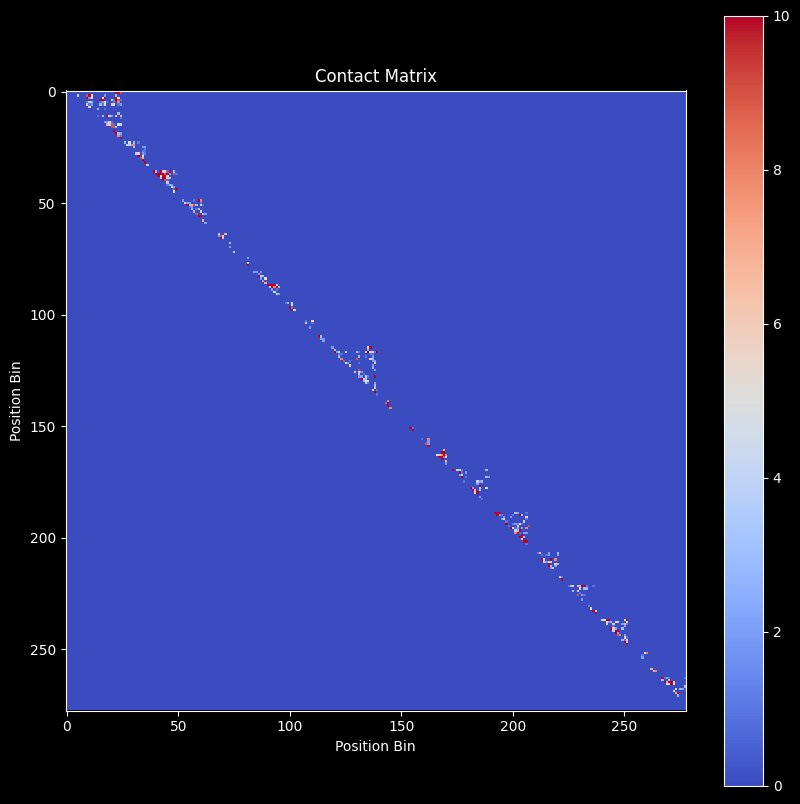

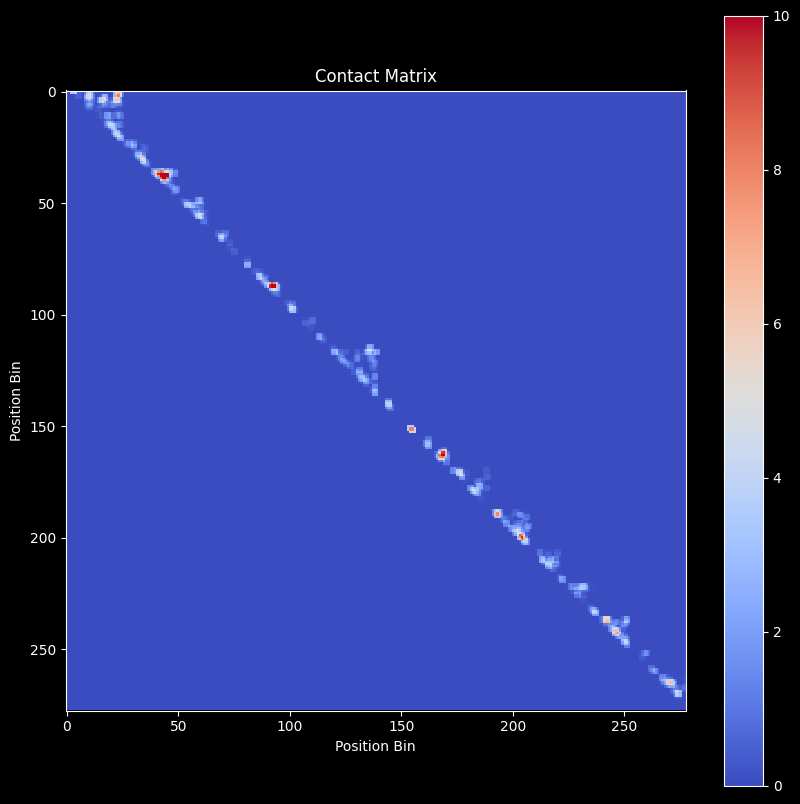

In [25]:
smoothed_matrix = apply_adjacent_smoothing(contact_matrices_Hela[2])
# Plot the original matrix
visualize(contact_matrices_Hela[2], 10)
visualize(smoothed_matrix, 10)

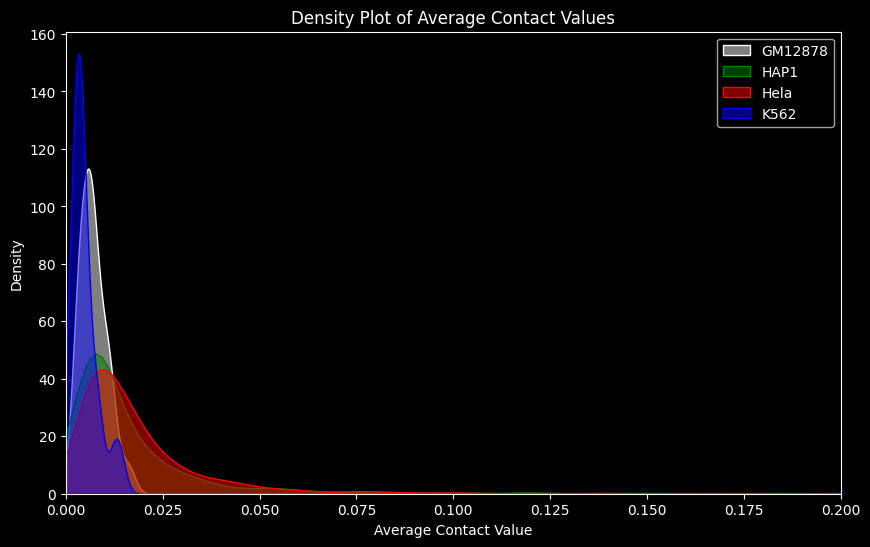

In [27]:
import seaborn as sns
data = [average_GM12878, average_HAP1, average_Hela, average_K562]
colors = ['white', 'green', 'red', 'blue']
labels = ['GM12878', 'HAP1', 'Hela', 'K562']

# Create the density plot
plt.figure(figsize=(10, 6))
for values, color, label in zip(data, colors, labels):
    sns.kdeplot(values, color=color, label=label, fill=True, alpha=0.5)

# Fix the x-axis range
plt.xlim(0, 0.2)

# Add titles and labels
plt.title('Density Plot of Average Contact Values')
plt.xlabel('Average Contact Value')
plt.ylabel('Density')
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [28]:
smoothed_GM12878 = [apply_adjacent_smoothing(matrix) for matrix in contact_matrices_GM12878]
smoothed_HAP1 = [apply_adjacent_smoothing(matrix) for matrix in contact_matrices_HAP1]
smoothed_Hela = [apply_adjacent_smoothing(matrix) for matrix in contact_matrices_Hela]
smoothed_K562 = [apply_adjacent_smoothing(matrix) for matrix in contact_matrices_K562]

In [85]:
# # Provided function to compare matrices with windows
# def compare_matrices_with_windows(matrix1, matrix2, window_size=20):
#     matrix_size = matrix1.shape[0]
#     result_size = matrix_size // window_size
#     result_matrix = np.zeros((result_size, result_size))
    
#     for i in range(result_size):
#         for j in range(result_size):
#             window1 = matrix1[i*window_size:(i+1)*window_size, j*window_size:(j+1)*window_size]
#             window2 = matrix2[i*window_size:(i+1)*window_size, j*window_size:(j+1)*window_size]
#             distance = mean_absolute_error(window1, window2)
#             result_matrix[i, j] = distance
            
#     return result_matrix

# # Function to compute the average distance matrix from two sets of matrices
# def compute_average_distance_matrix(set_a, set_b, window_size=10):
#     # List to store the distance matrices
#     distance_matrices = []

#     # Compare all pairs of matrices from set A and set B
#     for matrix_a in tqdm(set_a, desc='Comparing Set A to Set B'):
#         for matrix_b in set_b:
#             distance_matrix = compare_matrices_with_windows(matrix_a, matrix_b, window_size)
#             distance_matrices.append(distance_matrix)
    
#     # Compute the average distance matrix
#     average_distance_matrix = np.mean(distance_matrices, axis=0)
    
#     return average_distance_matrix

# average_distance_matrix = compute_average_distance_matrix(augmented_matrices_HAP1, augmented_matrices_Hela, window_size=10)


# # Find the indices of the top 5 highest scores in the average distance matrix
# num_top_spots = 5
# flat_indices = np.argpartition(average_distance_matrix.flatten(), -num_top_spots)[-num_top_spots:]
# top_indices = np.unravel_index(flat_indices, average_distance_matrix.shape)

# # Extract the top 5 values and their indices
# top_values = average_distance_matrix[top_indices]
# top_indices = list(zip(*top_indices))

# print("Top 5 highest scores and their indices:")
# for idx, val in zip(top_indices, top_values):
#     print(f"Index: {idx}, Value: {val:.2f}")

# # Plot the average distance matrix
# plt.figure(figsize=(10, 10))
# plt.imshow(average_distance_matrix, cmap='coolwarm', interpolation='none')
# plt.colorbar()
# plt.title('Average Structural Similarity Index Matrix')
# plt.xlabel('Window Position')
# plt.ylabel('Window Position')

# # Annotate the heatmap with the distance values
# for i in range(average_distance_matrix.shape[0]):
#     for j in range(average_distance_matrix.shape[1]):
#         plt.text(j, i, f'{average_distance_matrix[i, j]:.2f}', ha='center', va='center', color='black')

# # Highlight the top 5 highest scores
# for idx, val in zip(top_indices, top_values):
#     plt.text(idx[1], idx[0], f'{val:.2f}', ha='center', va='center', color='white', fontweight='bold', fontsize=10)

# plt.show()


In [30]:
# Function to flatten matrices
def flatten_matrices(matrices):
    return [matrix.flatten() for matrix in matrices]

flattened_GM12878 = flatten_matrices(contact_matrices_GM12878)
flattened_HAP1 = flatten_matrices(contact_matrices_HAP1)
flattened_Hela = flatten_matrices(contact_matrices_Hela)
flattened_K562 = flatten_matrices(contact_matrices_K562)

all_matrices = flattened_GM12878 + flattened_HAP1 + flattened_Hela + flattened_K562
labels = (
    [1] * len(flattened_GM12878) +
    [2] * len(flattened_HAP1) +
    [3] * len(flattened_Hela) +
    [4] * len(flattened_K562)
)
all_matrices = np.array(all_matrices)
labels = np.array(labels)


In [87]:
# # Apply t-SNE
# tsne = TSNE(n_components=3, perplexity=50, learning_rate=100, random_state=42)
# tsne_results = tsne.fit_transform(all_matrices)

# # Create a scatter plot of the t-SNE results
# df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2', 'TSNE3'])
# df_tsne['Label'] = labels

# # Plot the 3D t-SNE results using plotly
# fig = px.scatter_3d(
#     df_tsne, x='TSNE1', y='TSNE2', z='TSNE3',
#     color=df_tsne['Label'].astype(str),  # Convert labels to string for better color differentiation
#     title='3D t-SNE Visualization of Cell Line Clusters',
#     labels={'color': 'Cell Line'}
# )

# fig.show()

/Users/rogersyang/Documents/PhD Application/Research/3D DNA Structure Heterogeneity/DNA3D/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


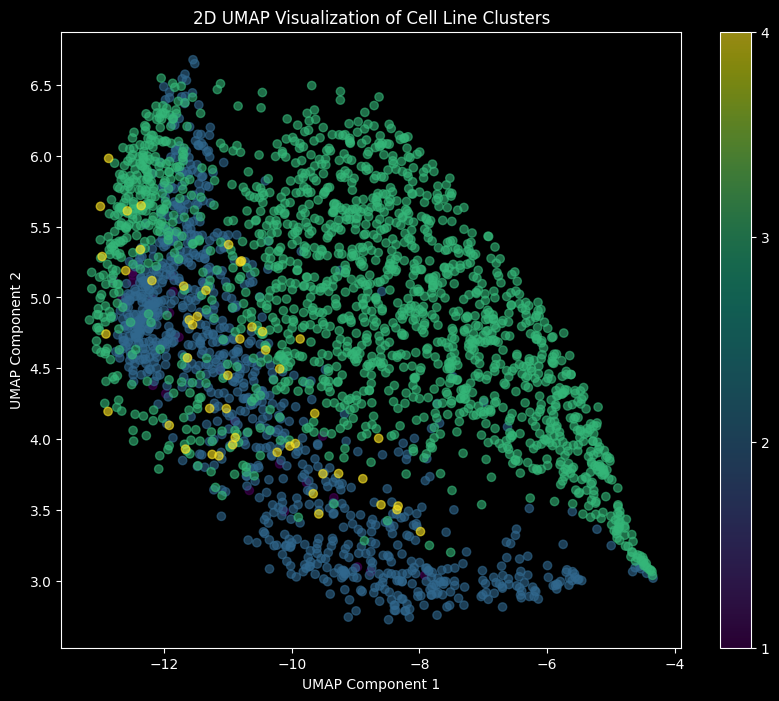

In [31]:
# Convert to NumPy arrays and ensure correct data types
all_matrices = np.array(all_matrices).astype(np.float64)
labels = np.array(labels).astype(np.int64)

# Apply UMAP with 2 components
umap_2d = UMAP(n_components=2, random_state=42)
umap_results_2d = umap_2d.fit_transform(all_matrices)

# 2D Visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_results_2d[:, 0], umap_results_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, ticks=[1, 2, 3, 4])
plt.title('2D UMAP Visualization of Cell Line Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [32]:
def chart(X, y):
    #--------------------------------------------------------------------------#
    # This section is not mandatory as its purpose is to sort the data by label 
    # so, we can maintain consistent colors for digits across multiple graphs
    
    # Concatenate X and y arrays
    arr_concat = np.concatenate((X, y.reshape(y.shape[0], 1)), axis=1)
    # Create a Pandas dataframe using the above array
    df = pd.DataFrame(arr_concat, columns=['x', 'y', 'z', 'label'])
    # Convert label data type from float to integer
    df['label'] = df['label'].astype(int)
    # Finally, sort the dataframe by label
    df.sort_values(by='label', axis=0, ascending=True, inplace=True)
    
    # Create a 3D graph
    fig = px.scatter_3d(df, x='x', y='y', z='z', color=df['label'].astype(str), height=900, width=950)

    # Update chart looks
    fig.update_layout(showlegend=True,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=-1.4, z=0.5)),
                      margin=dict(l=0, r=0, b=0, t=0),
                      scene=dict(xaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='#f0f0f0',
                                            title_font=dict(size=10),
                                            tickfont=dict(size=10)),
                                 yaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='#f0f0f0',
                                            title_font=dict(size=10),
                                            tickfont=dict(size=10)),
                                 zaxis=dict(backgroundcolor='lightgrey',
                                            color='black', 
                                            gridcolor='#f0f0f0',
                                            title_font=dict(size=10),
                                            tickfont=dict(size=10))))
    # Update marker size
    fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))
    
    fig.show()

In [33]:
# Configure UMAP hyperparameters
reducer = UMAP(n_neighbors=4, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=3, # default 2, The dimension of the space to embed into.
               metric='cosine', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=10000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1, # default 1.0, The initial learning rate for the embedding optimization.
               init='spectral', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0, # default 0.1, The effective minimum distance between embedded points.
               random_state=89
              )
transformed_data = reducer.fit_transform(all_matrices)

/Users/rogersyang/Documents/PhD Application/Research/3D DNA Structure Heterogeneity/DNA3D/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [34]:
chart(transformed_data, labels)

In [ ]:
# import os
# import numpy as np
# import pandas as pd
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# # Function to load and process matrices from a directory
# def load_and_process_matrices(directory):
#     matrices = []
#     for filename in os.listdir(directory):
#         if filename.endswith(".txt"):
#             filepath = os.path.join(directory, filename)
#             df = pd.read_csv(filepath, sep='\t', header=None)
#             df.columns = ['chr1', 'pos1', 'chr2', 'pos2', 'contact_count']
#             # Log10 transform contact counts
#             df['contact_count'] = np.log10(df['contact_count'] + 1)
#             # Binarize at 10 Mb resolution
#             df['bin1'] = df['pos1'] // 10000000
#             df['bin2'] = df['pos2'] // 10000000
#             # Ensure redundant entries are only represented once
#             df = df[df['chr1'] <= df['chr2']]
#             matrices.append(df)
#     return matrices

# # Function to vectorize matrices
# def vectorize_matrices(matrices):
#     contacts = {}
#     for df in matrices:
#         for _, row in df.iterrows():
#             contact = (row['chr1'], row['bin1'], row['chr2'], row['bin2'])
#             if contact not in contacts:
#                 contacts[contact] = []
#             contacts[contact].append(row['contact_count'])
    
#     # Create a dataframe where rows are single cells and columns are contacts
#     contact_list = list(contacts.keys())
#     vectorized_data = []
#     for df in matrices:
#         cell_vector = []
#         for contact in contact_list:
#             chr1, bin1, chr2, bin2 = contact
#             matching_rows = df[(df['chr1'] == chr1) & (df['bin1'] == bin1) & (df['chr2'] == chr2) & (df['bin2'] == bin2)]
#             if not matching_rows.empty:
#                 cell_vector.append(matching_rows['contact_count'].values[0])
#             else:
#                 cell_vector.append(0)
#         vectorized_data.append(cell_vector)
    
#     return pd.DataFrame(vectorized_data, columns=contact_list)

# # Directories of the four types of cells
# directories = ["./GM12878", "./HAP1", "./Hela", "./K562"]
# labels = ["GM12878", "HAP1", "Hela", "K562"]

# # Load, process, and vectorize matrices from each directory
# all_matrices = []
# all_labels = []
# for i, directory in enumerate(directories):
#     matrices = load_and_process_matrices(directory)
#     all_matrices.extend(matrices)
#     all_labels.extend([labels[i]] * len(matrices))

# # Vectorize matrices
# vectorized_matrix = vectorize_matrices(all_matrices)

# # Perform PCA
# pca = PCA(n_components=8)
# pca_result = pca.fit_transform(vectorized_matrix)

# # Convert the PCA result to a dataframe
# pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
# pca_df['label'] = all_labels

# # Plot the PCA result
# plt.figure(figsize=(10, 8))
# for label in labels:
#     indices = pca_df['label'] == label
#     plt.scatter(pca_df.loc[indices, 'PC1'], pca_df.loc[indices, 'PC2'], label=label)
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('PCA of Contact Matrices')
# plt.legend()
# plt.show()


In [23]:
# def pad_matrix(matrix, target_shape):
#     pad_height = target_shape[0] - matrix.shape[0]
#     pad_width = target_shape[1] - matrix.shape[1]
#     return np.pad(matrix, ((0, pad_height), (0, pad_width)), mode='constant')

# # Find the maximum size
# max_shape = (
#     max(max(matrix.shape[0] for matrix in group) for group in [contact_matrices_GM12878, contact_matrices_HAP1, contact_matrices_Hela, contact_matrices_K562]),
#     max(max(matrix.shape[1] for matrix in group) for group in [contact_matrices_GM12878, contact_matrices_HAP1, contact_matrices_Hela, contact_matrices_K562])
# )

# # Pad all matrices to the maximum size
# contact_matrices_GM12878 = [pad_matrix(matrix, max_shape) for matrix in contact_matrices_GM12878]
# contact_matrices_HAP1 = [pad_matrix(matrix, max_shape) for matrix in contact_matrices_HAP1]
# contact_matrices_Hela = [pad_matrix(matrix, max_shape) for matrix in contact_matrices_Hela]
# contact_matrices_K562 = [pad_matrix(matrix, max_shape) for matrix in contact_matrices_K562]

# flattened_data = {
#     'GM12878': flatten_matrices(contact_matrices_GM12878),
#     'HAP1': flatten_matrices(contact_matrices_HAP1),
#     'Hela': flatten_matrices(contact_matrices_Hela),
#     'K562': flatten_matrices(contact_matrices_K562)
# }

# from scipy.stats import f_oneway

# num_features = len(flattened_data['GM12878'][0])
# anova_results = []

# for i in range(num_features):
#     f_val, p_val = f_oneway(*[[flattened_data[group][j][i] for j in range(len(flattened_data[group]))] for group in flattened_data])
#     anova_results.append((i, f_val, p_val))

# # Select top features with the highest F-statistics
# anova_results = sorted(anova_results, key=lambda x: x[1], reverse=True)
# top_features = [result[0] for result in anova_results[:50]]  # Selecting top 50 features


In [27]:
# def create_feature_matrix(flattened_data, selected_features):
#     feature_matrix = []
#     labels = []
#     for group, data in flattened_data.items():
#         for instance in data:
#             feature_matrix.append([instance[i] for i in selected_features])
#             labels.append(group)
#     return np.array(feature_matrix), np.array(labels)

# selected_features_matrix, labels = create_feature_matrix(flattened_data, top_features)


(2611,)
(2611, 50)


In [28]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(selected_features_matrix)


In [ ]:
# import matplotlib.pyplot as plt

# def visualize_pca(pca_result, labels):
#     plt.figure(figsize=(10, 8))
#     for group in np.unique(labels):
#         indices = np.where(labels == group)
#         plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=group)
#     plt.legend()
#     plt.title('PCA of Cell Groups')
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
#     plt.show()

# visualize_pca(pca_result, labels)